In [434]:
import numpy as np
import pandas as pd
import keras as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dropout, Dense,Dot,Concatenate,BatchNormalization,Multiply
from keras.optimizers import adam_v2

from keras.utils.vis_utils import plot_model

Loading data

In [435]:
#ratings = pd.read_csv("Movie Recommendation Lab/ratings.csv", header=0, names=['user_id', 'movie_id', 'rating'])
#movies = pd.read_csv("Movie Recommendation Lab/movies.tsv", header=0, sep='\t',names=['movie_id', 'name', 'year', 'genre1', 'genre2'])
#users = pd.read_csv("Movie Recommendation Lab/users.csv", header=0, names=['user_id', 'age', 'gender'])
np.random.seed(100)
names=['user_id', 'age', 'gender','movie_id', 'name', 'year', 'genre1', 'genre2', 'genre3','rating']
alldata = pd.read_csv("Movie Recommendation Lab/allData.tsv", header=0, sep='\t',names=names)
alldata = alldata.drop(axis=1,columns='name')
alldata.head()

,user_id,age,gender,movie_id,year,genre1,genre2,genre3,rating
0,747,1,F,1193,1975,Drama,NaN,NaN,5
1,747,1,F,661,1996,Animation,Children's,Musical,3
2,747,1,F,2804,1983,Comedy,Drama,NaN,5
3,747,1,F,919,1939,Adventure,Children's,Drama,4
4,747,1,F,2791,1980,Comedy,NaN,NaN,4


Count the number of categories ids,gender,genre1

In [436]:
#change spares user_id and movie_id in to a sequence from 1 to number of movies and users in
movie_id_to_new_id = dict()
user_id_to_new_id = dict()
rating_to_category = {1:[1,0,0,0,0,0],2:[0,1,0,0,0,0],3:[0,0,1,0,0,0],4:[0,0,0,0,1,0],5:[0,0,0,0,1]}
genre_to_id = dict()
genre_to_id[np.nan] = 1
genre_id = 2
movie_id = 1
user_id = 1
for index, row in alldata.iterrows():
    #count movie ids and order
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = movie_id
        alldata.at[index, 'movie_id'] = movie_id
        movie_id += 1
    else:
        alldata.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])
        
    if user_id_to_new_id.get(row['user_id']) is None:
        user_id_to_new_id[row['user_id']] = user_id
        alldata.at[index, 'user_id'] = user_id
        user_id += 1
    else:
        alldata.at[index, 'user_id'] = user_id_to_new_id.get(row['user_id'])
    
    if genre_to_id.get(row['genre1']) is None:
        genre_to_id[row['genre1']] = genre_id
        alldata.at[index, 'genre1'] = genre_id
        genre_id += 1
    else:
        alldata.at[index, 'genre1'] = genre_to_id.get(row['genre1'])
    
    if genre_to_id.get(row['genre2']) is None:
        genre_to_id[row['genre2']] = genre_id
        alldata.at[index, 'genre2'] = genre_id
        genre_id += 1
        
    else:
        alldata.at[index, 'genre2'] = genre_to_id.get(row['genre2'])
    
    if genre_to_id.get(row['genre3']) is None:
        genre_to_id[row['genre3']] = genre_id
        alldata.at[index, 'genre3'] = genre_id
        genre_id += 1
    else:
        alldata.at[index, 'genre3'] = genre_to_id.get(row['genre3'])    
    
    if row['gender'] == 'M':
        alldata.at[index, 'gender'] = 1
    else:
        alldata.at[index, 'gender'] = 2
        
    
alldata['rating'] = alldata['rating'].map(lambda x: x/5)
num_users = max(alldata['user_id'].unique())
num_movies = max(alldata['movie_id'].unique())
num_genre1 = max(alldata['genre1'].unique())
num_genre2 = max(alldata['genre2'].unique())
num_genre3 = max(alldata['genre3'].unique())

train, test = train_test_split(alldata, test_size=0.2)




In [437]:
num_genre1,num_genre2,num_genre3

(19, 19, 18)

In [438]:
num_users,num_movies

(2353, 1465)

Embeding catgory part

In [439]:
id_dim =6


movie_id_input = Input(shape=[1],name='movie-id-input')
movie_id_embedding = Embedding(num_movies + 1, id_dim, name='movie-id-embedding')(movie_id_input)
movie_id_vec = Flatten(name='movie-flatten')(movie_id_embedding)

user_id_input = Input(shape=[1],name='user-id-input')
user_id_embedding = Embedding(num_users + 1, id_dim, name='user-id-embedding')(user_id_input)
user_id_vec = Flatten(name='user-flatten')(user_id_embedding)

genre_dim = 6
genre1_input = Input(shape=[1],name='gener1')
genre1_embedding = Embedding(num_genre1 + 1, genre_dim, name='gener1-embedding')(genre1_input)
genre1_vec = Flatten(name='gener1_flatten')(genre1_embedding)

genre2_input = Input(shape=[1],name='gener2')
genre2_embedding = Embedding(num_genre2 + 1, genre_dim, name='gener2-embedding')(genre2_input)
genre2_vec = Flatten(name='gener2_flatten')(genre2_embedding)

genre3_input = Input(shape=[1],name='gener3')
genre3_embedding = Embedding(num_genre3 + 1, genre_dim, name='gener3-embedding')(genre3_input)
genre3_vec = Flatten(name='gener3_flatten')(genre3_embedding)

gender_dim = 6
gender_input = Input(shape=[1],name='gender')
gender_embedding = Embedding(3, gender_dim, name='gender-embedding')(gender_input)
gender_vec = Flatten(name='gender_flatten')(gender_embedding) 

age_input = Input(shape=[1],name='age_input')
year_input = Input(shape=[1],name='year_input')



Model building: wide part

deep Neural part

In [440]:
DN_input_list=[movie_id_vec,user_id_vec,genre1_vec,genre2_vec,genre3_vec,gender_vec,age_input,year_input]
concatenate = Concatenate(axis=-1)(DN_input_list)
con_bn = BatchNormalization(name='con_batch-norm')(concatenate)
fc_1 = Dense(24, name='fc-1', activation='relu')(con_bn)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1_bn)
fc_2 = Dense(12, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)


wide part

In [441]:
wide_list=[genre1_input,genre2_input,genre3_input,gender_input,movie_id_input,user_id_input,]
doct_product = Multiply()(wide_list)
doct_product_bn = BatchNormalization(name='doct_product_batch-norm-2')(doct_product)

compile

In [442]:
input_list = [movie_id_input,user_id_input,genre1_input,genre2_input,genre3_input,gender_input,age_input,year_input]

concatenate2 = Concatenate(axis=1)([fc_2_bn,doct_product_bn])
bn = BatchNormalization(name='batch-norm-4')(concatenate2)
logistic= Dense(1,name='logistic',activation='sigmoid')(bn)
model = Model(input_list,logistic )
model.compile(optimizer=adam_v2.Adam(lr=0.1), loss='mean_squared_error')

D:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


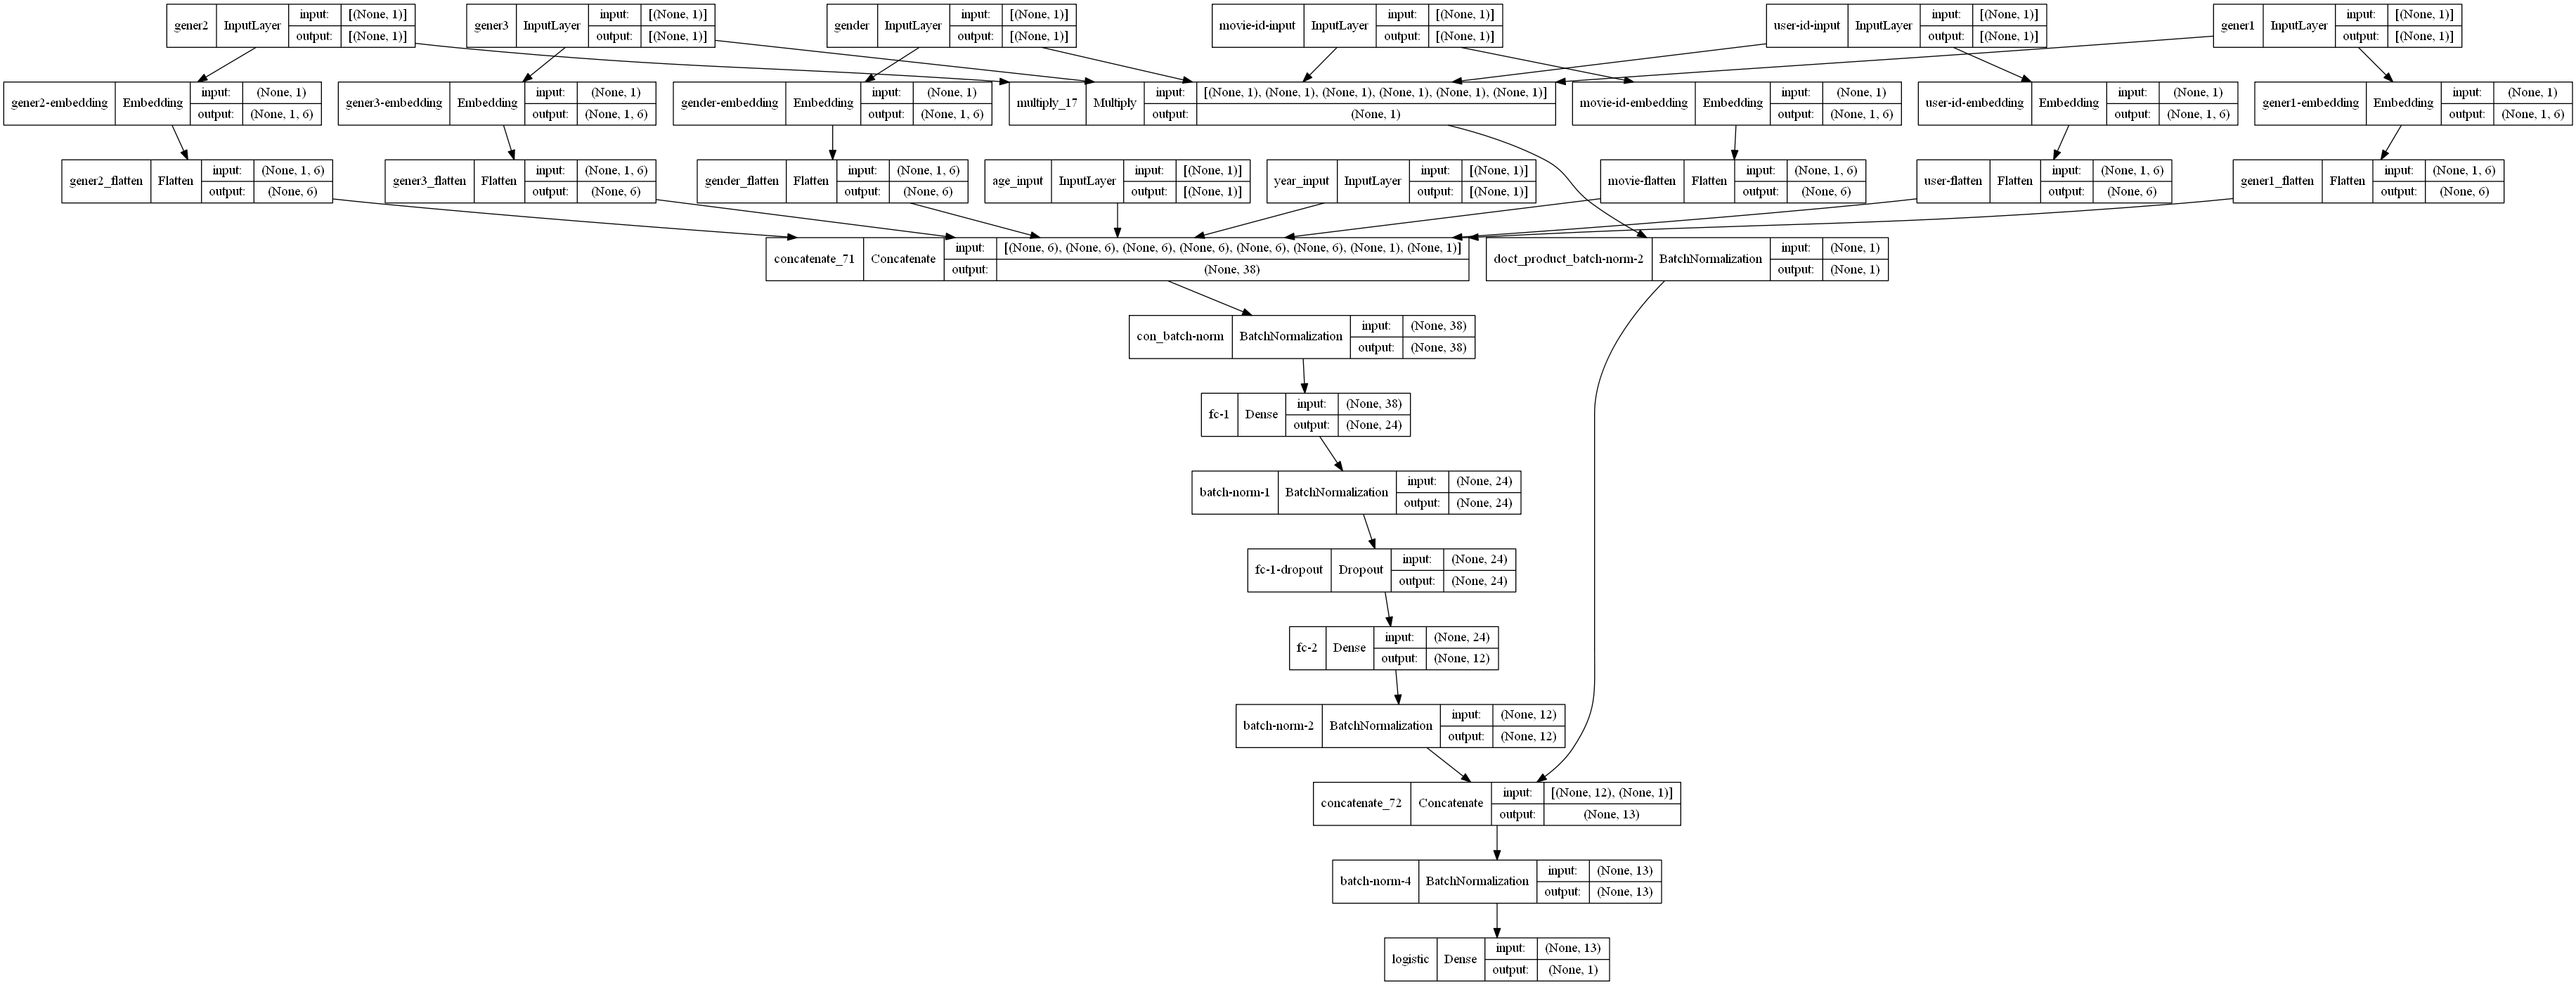

In [443]:
plot_model(model, to_file='model.png',show_shapes=True)

In [444]:
model.summary()

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-id-input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 user-id-input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 gener1 (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 gener2 (InputLayer)            [(None, 1)]          0           []                               
                                                                                           

train and test

Epoch 1/10
791/791 [==============================] - 2s 1ms/step - loss: 0.0435
Epoch 2/10
791/791 [==============================] - 1s 1ms/step - loss: 0.0367
Epoch 3/10
791/791 [==============================] - 1s 1ms/step - loss: 0.0352
Epoch 4/10
791/791 [==============================] - 1s 1ms/step - loss: 0.0335
Epoch 5/10
791/791 [==============================] - 1s 1ms/step - loss: 0.0326
Epoch 6/10
791/791 [==============================] - 1s 1ms/step - loss: 0.0320
Epoch 7/10
791/791 [==============================] - 1s 1ms/step - loss: 0.0322
Epoch 8/10
791/791 [==============================] - 1s 1ms/step - loss: 0.0312
Epoch 9/10
791/791 [==============================] - 1s 1ms/step - loss: 0.0311
Epoch 10/10
791/791 [==============================] - 1s 1ms/step - loss: 0.0303


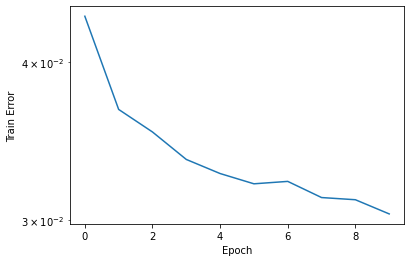

mean_absolute_error =  0.7738298594216468


In [445]:
train = train.astype('float64')
test = test.astype('float64')
train_inputs = [train.movie_id,train.user_id,train.genre1, train.genre2,train.genre3,train.gender, train.age,train.year]
test_inputs = [test.movie_id,test.user_id ,test.genre1, test.genre2,test.genre3,test.gender, test.age,test.year]
history = model.fit(train_inputs, train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()
y_hat = np.round(model.predict(test_inputs), decimals=2)
y_true = test.rating
y1 = [i * 5 for i in y_true]
y2= [i * 5 for i in y_hat]

print('mean_absolute_error = ',mean_absolute_error(y1, y2))

In [446]:
y_true

27121    0.8
24988    0.6
12014    0.6
57       1.0
10175    0.8
        ... 
12135    0.6
31161    0.6
23094    0.8
28791    0.8
8447     0.8
Name: rating, Length: 6324, dtype: float64

(array([ 384.,    0.,  674.,    0., 1648.,    0.,    0., 2257.,    0.,
        1361.]),
 array([0.2 , 0.28, 0.36, 0.44, 0.52, 0.6 , 0.68, 0.76, 0.84, 0.92, 1.  ]),
 <BarContainer object of 10 artists>)

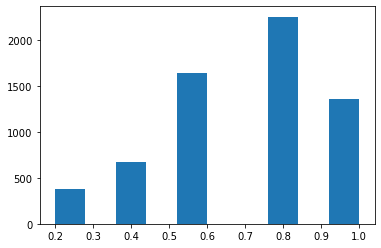

In [447]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns


plt.hist(y_true )


(array([  11.,   97.,  264.,  313.,  381., 1136., 1614., 1065.,  973.,
         470.]),
 array([0.11 , 0.198, 0.286, 0.374, 0.462, 0.55 , 0.638, 0.726, 0.814,
        0.902, 0.99 ], dtype=float32),
 <BarContainer object of 10 artists>)

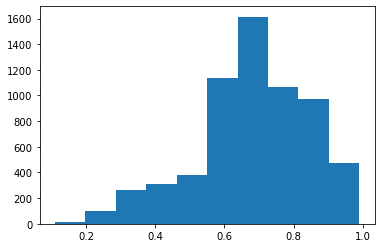

In [448]:
plt.hist(y_hat)